In [1]:
import torch
import torchvision
import requests
from pycocotools.coco import COCO
from PIL import Image, ImageOps

In [2]:
image_path = '/opt/ml/upstage_OCR/datas/Data set/real data/general/0000.jpg'

image = Image.open(image_path)
image = ImageOps.exif_transpose(image)

image = torchvision.transforms.ToTensor()(image)
image_gray = torchvision.transforms.Grayscale()(image)

In [4]:
def get_ann(img_path,api_url) -> dict:
    headers = {"secret": "Boostcamp0000"}
    file_dict = {"file": open(img_path  , "rb")}
    response = requests.post(api_url, headers=headers, files=file_dict)
    return response.json()

ann_dict = get_ann(image_path,"http://118.222.179.32:30000/ocr/")
coco_dict = {
    'images':[{
        'filename':image_path,
        'height': image.shape[1],
        'width': image.shape[2],
        'id': 0
    }],
    'categories':[
        {
            'id':1,
            "name": "text"
        }
    ],
    'annotations':[]
}

for i,box in enumerate(ann_dict['ocr']['word']):
    coco_dict['annotations'].append({
        'id':i,
        'image_id':0,
        'category_id':1,
        'text': box['text'],
        'segmentation': [[]]
    })
    for point in box['points']:
        coco_dict['annotations'][-1]['segmentation'][0] += point

coco = COCO(coco_dict)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
import numpy as np

c1 = np.zeros((1,image.shape[1], image.shape[2]))
c2 = np.zeros((1,image.shape[1], image.shape[2]))

for ann in coco.anns.values():
    c1[0][coco.annToMask(ann) == 1] = ann['category_id']

id_list = ['ID', 'ID:', '아이디', 'NETWORK', '네트워크']
pw_list = ['PW', 'PW:', '비밀번호','PASSCODE', 'PASSWORD', '패스워드']
key_list = id_list + pw_list + [':','WIFI', '1층', '2층', '3층', '4층', 'FREE', 'WI-FI', 'KT', 'GIGA','와이파이']

for ann in coco.anns.values():
    if any(map(lambda x: x in ann['text'],key_list)):
        c2[0][coco.annToMask(ann) == 1] = ann['category_id']
        print('key :', ann['text'])
    else:
        print('passed :', ann['text'])
        pass

c1 = torch.from_numpy(c1)
c2 = torch.from_numpy(c2)
out = torch.cat((image_gray,c1,c2))

passed : 매
passed : 무료
passed : 스
passed : 2
passed : S
passed : 아메리카노
passed : OFFEE
passed : 연
passed : 보이미지는
passed : in
passed : 왕으로ㄹ
passed : i
passed : 설제외
passed : 수
passed : >
passed : READ
passed : 1
key : 와이파이명
passed : TOMNTOMS
passed : 2G_
key : :
key : 1층
passed : #
passed : 1
passed : TOMNTOMS_5G_
key : (WI-FI)
passed : 2G
passed : TOMNTOMS
passed : 2
passed : an
key : 2층
passed : 2
passed : TOMNTOMS_5G
passed : _3
passed : TOMNTOMS_2G
key : 3층
passed : TOMNTOMS_5G
passed : 3
passed : _4
passed : 2G
passed : TOMNTOMS
key : 4층
passed : 4
passed : 5G
passed : I
passed : TOMNTOMS
passed : in
passed : ghkdid4565!
key : 패스워드
key : :
key : 3층
passed : 남자화장실
key : :
passed : ♂
key : 4층
key : 2층,
passed : ♀여자화장실
key : :
passed : 이용해주세요.
passed : 서비스바를
passed : 왼편
passed : 홀더는
passed : 냅킨,
passed : 물,
passed : 내
passed : 매장
passed : 따라
passed : 자원재활용법에
passed : 어려워져
passed : 제공이
passed : 스트로우(빨대)
passed : 자율적인
passed : 드립니다.
passed : 말씀
passed : 양해
passed : 고객분들께
passed : 주세요!
pas

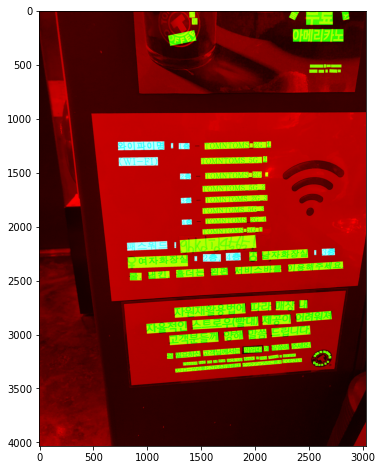

In [14]:
import matplotlib.pyplot as plt
t = torchvision.transforms.Compose(
    [torchvision.transforms.ToPILImage()]
)
plt.figure(figsize=(25,8))
plt.imshow(t(out))

plt.show()